# **Regressão Logística - pt. II**

Agora que já aprendemos a ajustar uma regressão logística a um conjunto de dados, podemos aprofundar a nossa análise para entender como o limite mínimo de probabilidade altera os resultados.

Primeiramente, vamos realizar a modelagem novamente e estimar as probabilidades, dessa vez:

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, \
                            precision_score, recall_score, precision_recall_curve, \
                            roc_curve, roc_auc_score

# ignorar warnings
warnings.filterwarnings('ignore')

In [ ]:
# montando drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# procurando arquivos no Drive
data = pd.read_csv('/content/drive/MyDrive/ALGORITMOS DE IA/DATASET/drug200.csv', sep=',')
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [ ]:
#passos para fazer ao analisar os dados
#adicionar dependencias
#carregar os dados dos dataset
#analisar de dados
#normalizar dados das colunas
#verificar dados nullos
#verificar dados categoricos
#verificar representatividade dos dados do objetivo em relação ao restante dos dados
#(objetivo = 1, restante = 0)
#normalizar os dados
#verificar separabilidade linear
#separar os dados treino / teste estratificando
#definir o baseline otimista / pessimista
#gerar os dados estatisticos
#otimizacao verificar os falsos positivos e falsos negativos em funcao do limiar minimo
#otimizacao verificar o precisao e recall em funcao do limiar minimo
#otimizacao verificar curva ROC vs classificador aleatorio
#otimizacao lucro medio em relacao ao limiar minimo
#gerar o modelo e os dados estatisticos
#comparar com os modelos otimista e pessimistas


In [ ]:
# modificando os nomes das colunas
data.columns = data.columns.str.lower().str.replace(' ', '_')

In [ ]:
#vamos transformar drugC em 1 o restante em 0
data['drug'] = data['drug'].apply(lambda r:1 if r == 'drugC' else 0)

In [ ]:
#vamos transformar BP HIGH em 3, NORMAL em 2, LOW em 1
data['bp'].value_counts()

,count
bp,
HIGH,77
LOW,64
NORMAL,59


In [ ]:
data['bp'] = data['bp'].apply(lambda r:3 if r == 'HIGH' else 2 if r == 'NORMAL' else 1)
data.head()

,age,sex,bp,cholesterol,na_to_k,drug
0,23,F,3,HIGH,25.355,0
1,47,M,1,HIGH,13.093,1
2,47,M,1,HIGH,10.114,1
3,28,F,2,HIGH,7.798,0
4,61,F,1,HIGH,18.043,0


In [ ]:
#vamos transformar SEX em M 1 e F 0
data['sex'].value_counts()

,count
sex,
M,104
F,96


In [ ]:
data['sex'] = data['sex'].apply(lambda r:1 if r == 'M' else 0)
data.head()

,age,sex,bp,cholesterol,na_to_k,drug
0,23,0,3,HIGH,25.355,0
1,47,1,1,HIGH,13.093,1
2,47,1,1,HIGH,10.114,1
3,28,0,2,HIGH,7.798,0
4,61,0,1,HIGH,18.043,0


In [ ]:
#vamos transformar cholesterol HIGH = 1, NORMAL = 0
data['cholesterol'].value_counts()

,count
cholesterol,
HIGH,103
NORMAL,97


In [ ]:
data['cholesterol'] = data['cholesterol'].apply(lambda r:1 if r == 'HIGH' else 0)
data.head()

,age,sex,bp,cholesterol,na_to_k,drug
0,23,0,3,1,25.355,0
1,47,1,1,1,13.093,1
2,47,1,1,1,10.114,1
3,28,0,2,1,7.798,0
4,61,0,1,1,18.043,0


In [ ]:
# para iniciar nosso trabalho, vamos começar selecionando apenas as variáveis numéricas
cols = ['age', 'sex', 'bp', 'na_to_k','drug']
data = data[cols]

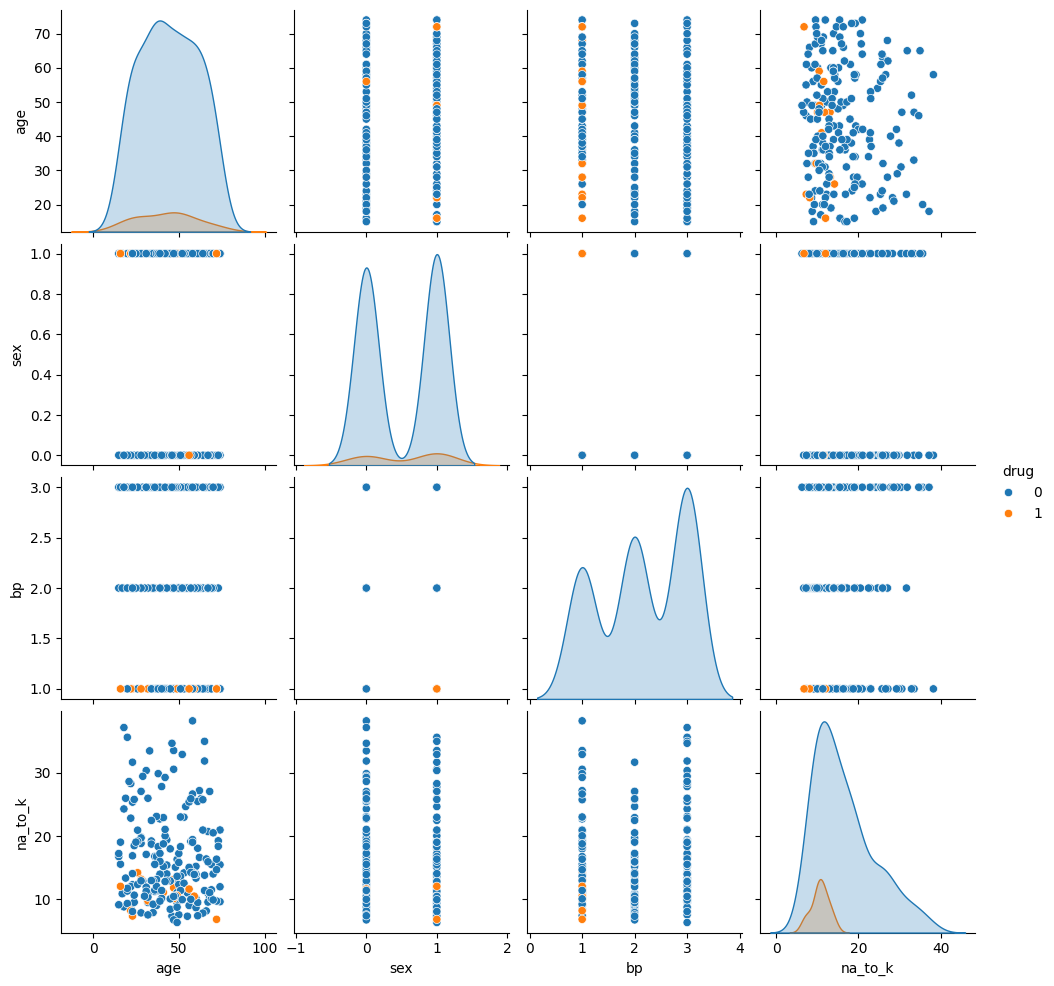

In [ ]:
# analise de separabilidade linear (visual)
sns.pairplot(data, hue='drug')

In [ ]:
# separando x e y
x = data.drop(['drug'], axis=1)
y = data[['drug']]

In [ ]:
x.shape

(200, 4)

In [ ]:
y.shape

(200, 1)

In [ ]:
# separando treino e teste - com estratificação
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

In [ ]:
#dados de treino abaixo

In [ ]:
x_train.shape

(140, 4)

In [ ]:
y_train.shape

(140, 1)

In [ ]:
#dados de teste abaixo

In [ ]:
x_test.shape

(60, 4)

In [ ]:
y_test.shape

(60, 1)

In [ ]:
# criando um pipeline de modelagem
pipe_rl = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('rl2', LogisticRegression(penalty=None))
])

# ajustando o pipeline
pipe_rl.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rl2', LogisticRegression(penalty=None))])

In [ ]:

#fazendo previsao do teste
yhat_rl1 = pipe_rl.predict(x_test)

#analisando metricas
print(classification_report(y_test, yhat_rl1))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93        55
           1       0.40      0.80      0.53         5

    accuracy                           0.88        60
   macro avg       0.69      0.85      0.73        60
weighted avg       0.93      0.88      0.90        60



Normalmente, usamos o método `.predict()` para obter as classes que cada uma das amostras pertence.

No entanto, podemos usar também o método `.predict_proba()` para obter as estimativas de probabilidade de pertencimento.

In [ ]:
# quero fazer a previsao de uma unica linha
# vamos analisar a primeira linha do conjunto de teste
row = x_test.iloc[[0], :]
row

,age,sex,bp,na_to_k
9,43,1,1,19.368


In [ ]:
# analisando as probabilidades
probs = pipe_rl.predict_proba(row)
probs

array([[0.98753276, 0.01246724]])

No caso acima, a classe escolhida seria a classe 1, visto que sua probabilidade de pertecimento é maior.

A probabilidade mínima para pertencer a uma classe é 0.5, por padrão. No entanto, podemos modificar esse limiar, conforme as necessidades do nosso negócio.

- se $p_{decision} > 0.5 \to$ dizemos que o modelo se torna mais **conservador**, pois será necessária uma "certeza maior" para que um ponto pertença a uma classe. Como efeito colateral, teremos um aumento de falsos negativos.

- se $p_{decision} < 0.5 \to$ dizemos que o modelo se torna mais **liberal**, pois será necessária uma "certeza menor" para que um ponto pertença a uma classe. Como efeito colateral, teremos um aumento de falsos positivos.

Façamos uma análise gráfica desse efeito:

In [ ]:
# criando um vetor de probabilidades
prob_min = np.linspace(0.01, 0.99, 99)
prob_min

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [ ]:
# realizando a previsão das probabilidades de toda base de teste
prob_test = pipe_rl.predict_proba(x_test)
prob_test

array([[9.87532761e-01, 1.24672387e-02],
       [9.99996240e-01, 3.76005075e-06],
       [9.99993432e-01, 6.56783936e-06],
       [5.69101686e-01, 4.30898314e-01],
       [9.72140635e-01, 2.78593647e-02],
       [3.74054515e-02, 9.62594548e-01],
       [1.00000000e+00, 1.60754811e-11],
       [1.54836034e-01, 8.45163966e-01],
       [9.99913698e-01, 8.63024970e-05],
       [9.99997030e-01, 2.97012030e-06],
       [9.99999998e-01, 2.07823830e-09],
       [1.00000000e+00, 5.59059230e-11],
       [9.99983162e-01, 1.68377420e-05],
       [4.99849589e-01, 5.00150411e-01],
       [9.99970958e-01, 2.90416357e-05],
       [1.00000000e+00, 9.28222294e-11],
       [9.97411031e-01, 2.58896901e-03],
       [9.99999225e-01, 7.74947797e-07],
       [1.00000000e+00, 1.31178664e-10],
       [9.99999979e-01, 2.08648893e-08],
       [9.99999788e-01, 2.12206757e-07],
       [1.00000000e+00, 2.94911878e-11],
       [9.99999997e-01, 2.52282664e-09],
       [6.49088522e-01, 3.50911478e-01],
       [1.000000

In [ ]:
FP = []
FN = []

for p in prob_min:

  # calculando o vetor de classes
  yhat = [1 if c[1] > p else 0 for c in prob_test]

  # calculando a matriz de confusão
  mc = confusion_matrix(y_test, yhat)

  # alimentar as listas
  FP.append(mc[0, 1] / y_test.shape[0])
  FN.append(mc[1, 0] / y_test.shape[0])

In [ ]:
FP

[0.2,
 0.18333333333333332,
 0.15,
 0.15,
 0.15,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.08333333333333333,
 0.08333333333333333,
 0.08333333333333333,
 0.0833

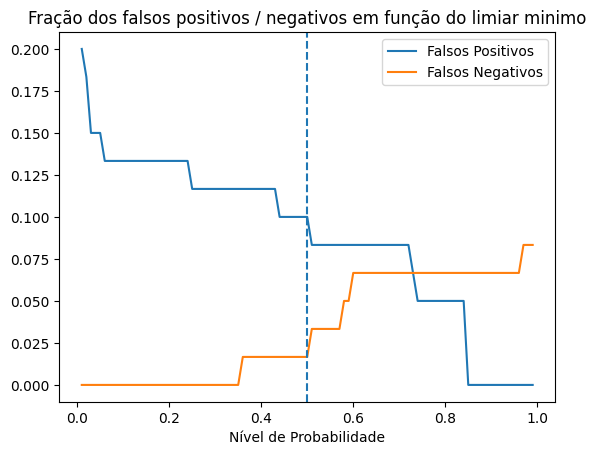

In [ ]:
plt.plot(prob_min, FP, label='Falsos Positivos')
plt.plot(prob_min, FN, label='Falsos Negativos')
plt.title('Fração dos falsos positivos / negativos em função do limiar minimo')
plt.xlabel('Nível de Probabilidade')
plt.axvline(x=0.5, ls='--')
plt.legend()
plt.show()

Podemos olhar esses resultados em termos de métricas bem conhecidas:

- **Gráfico Recall x Precisão**
- **Curva ROC** - curva que plota a Taxa de Verdadeiros Positivos (TPR) contra a Taxa de Falsos Positivos (FPR)

In [ ]:
precision = []
recall = []

for p in prob_min:

  # calculando o vetor de classes
  yhat = [1 if c[1] > p else 0 for c in prob_test]

  # alimentar as listas
  precision.append(precision_score(y_test, yhat))
  recall.append(recall_score(y_test, yhat))

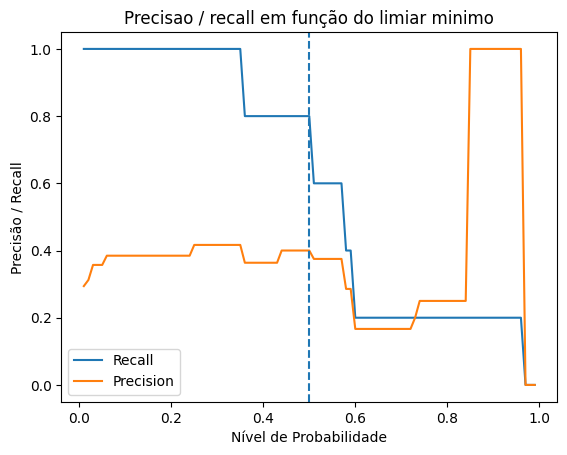

In [ ]:
plt.plot(prob_min, recall, label='Recall')
plt.plot(prob_min, precision, label='Precision')
plt.xlabel('Nível de Probabilidade')
plt.ylabel('Precisão / Recall')
plt.axvline(x=0.5, ls='--')
plt.title('Precisao / recall em função do limiar minimo')
plt.legend()
plt.show()

In [ ]:
#avaliando a curva de recall e precisao
precision, recall, _ = precision_recall_curve(y_test, [c[1] for c in prob_test])

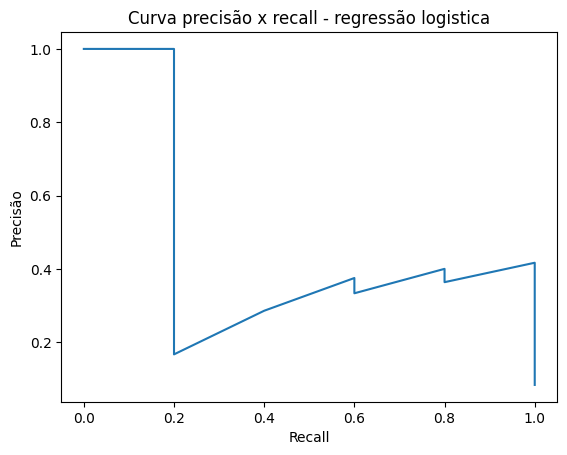

In [ ]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva precisão x recall - regressão logistica')
plt.show()

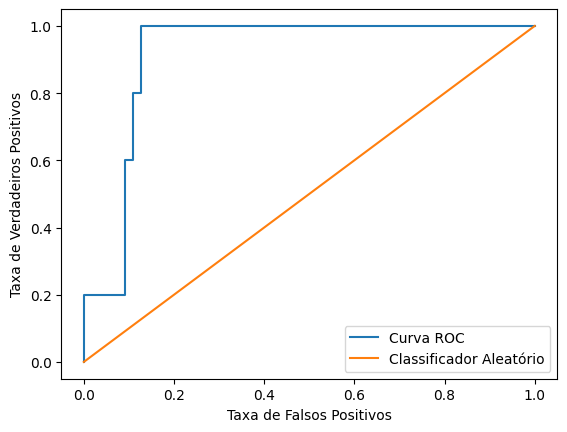

In [ ]:
fpr, tpr, _ = roc_curve(y_test, [c[1] for c in prob_test])

plt.plot(fpr, tpr, label='Curva ROC')
plt.plot([0, 1], [0, 1], label='Classificador Aleatório')
plt.legend()
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.show()

In [ ]:
# outra métrica de avaliação - relacionada com a variância do modelo
print('Área abaixo da curva AUC ROC:', roc_auc_score(y_test, [c[1] for c in prob_test]))

Área abaixo da curva AUC ROC: 0.9163636363636364


Por último, vamos adotar uma postura mais voltada aos negócios, considerando o lucro médio de cada cliente que foi classificado:

In [ ]:
def profit(yreal, ypred):
  # calcular a matriz de confuscao
  cm = confusion_matrix(yreal, ypred)

  # extrair pontuações
  tp = cm[1, 1] # verdadeiros positivos
  fp = cm[0, 1] # falsos positivos
  tn = cm[0, 0] # verdadeiros negativos
  fn = cm[1, 0] # falsos negativos

  # lucro total
  lucro = (50 * tp) + (-5 * fn) + (-5 * tn) + (-150 * fp)

  # retornar o lucro medio por cliente
  return lucro / yreal.shape[0]

In [ ]:
# avaliando o lucro medio em cada limiar
avg_profit = []

for p in prob_min:

  # calculando o vetor de classes
  yhat = [1 if c[1] > p else 0 for c in prob_test]

  # adicionar lucro a lista
  avg_profit.append(profit(y_test, yhat))

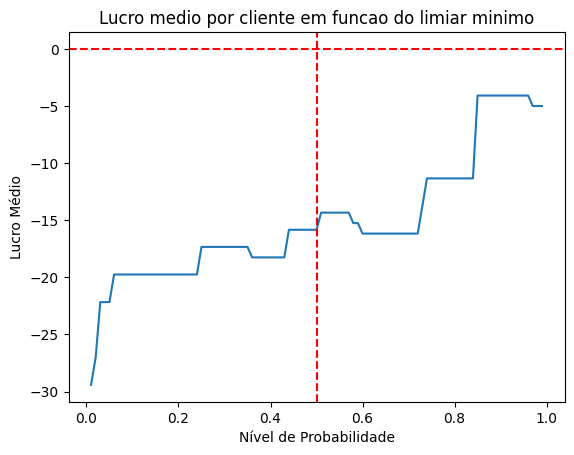

In [ ]:
plt.plot(prob_min, avg_profit, label='Lucro Médio')
plt.ylabel('Lucro Médio')
plt.xlabel('Nível de Probabilidade')
plt.title('Lucro medio por cliente em funcao do limiar minimo')
plt.axhline(y=0, color='red', ls='--')
plt.axvline(x=0.5, color='red', ls='--')
plt.show()

In [ ]:
# realizar a analise de limiar para o drug200 (condicoes aula 2)
# determinar programaticamente o ponto de operação (lucro medio maximo) - para o drug200

In [ ]:
def customer_cost(yreal, ypred):

  # calcula a matriz de confusão
  conf_matrix = confusion_matrix(yreal, ypred)

  # extrai pontuações
  TP = conf_matrix[1, 1]  # Verdadeiros positivos
  FP = conf_matrix[0, 1]  # Falsos positivos
  TN = conf_matrix[0, 0]  # Verdadeiros negativos
  FN = conf_matrix[1, 0]  # Falsos negativos

  # calcula custo
  return ((50 * TP) + (-5 * FN) + (-5 * TN) + (-150 * FP)) / yreal.shape[0]

In [ ]:
cost = []

for p in prob_min:

  # calculando o vetor de classes
  yhat = [1 if c[1] > p else 0 for c in prob_test]

  # alimentar as listas
  cost.append(customer_cost(y_test, yhat))

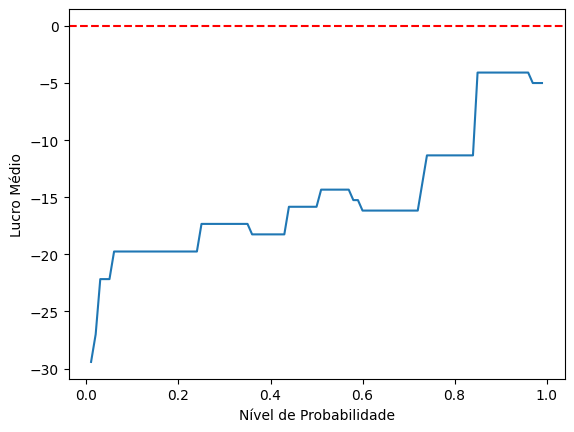

In [ ]:
plt.plot(prob_min, cost, label='Lucro Médio')
plt.ylabel('Lucro Médio')
plt.xlabel('Nível de Probabilidade')
plt.axhline(y=0, color='red', ls='--')
plt.show()